In [13]:
from utils import *
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import random
import warnings
import time
warnings.filterwarnings('ignore')

In [14]:
%store -r data
%store -r target

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(target)

In [16]:
data = standardize(data)
X_dev, y_dev, X_test, y_test, X_train, y_train, X_val, y_val = split(data,label)

X_train shape: (8091, 51)
X_test shape: (999, 51)
X_val shape: (900, 51)
y_train shape: (8091,)
y_test shape: (999,)
y_val shape: (900,)


### Original Model
Building a model with no parameter tuning and using the raw csv file

In [17]:
xgb_start_time = time.monotonic()
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_dev, y_dev)
xgb_end_time = time.monotonic()

predsDevxgb = model_xgb.predict(X_dev)
predsTestxgb = model_xgb.predict(X_test)

In [18]:
testxgb_score =  accuracy_score(y_test, predsTestxgb)
devxgb_score = accuracy_score(y_dev, predsDevxgb)

In [19]:
print("Classification Score for XGB Classifier on Dev dataset:\n")
print("Dev Score : ", devxgb_score)
print(classification_report(y_dev, predsDevxgb))
print("--------------------------------------------------------")
print("Classification Score for XGB Classifier on Test dataset:\n")
print("Test Score :", testxgb_score)
print(classification_report(y_test, predsTestxgb))

Classification Score for XGB Classifier on Dev dataset:

Dev Score :  0.9991102213324435
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       904
           1       1.00      1.00      1.00       894
           2       1.00      1.00      1.00       886
           3       1.00      1.00      1.00       890
           4       1.00      1.00      1.00       901
           5       1.00      1.00      1.00       886
           6       1.00      0.99      1.00       923
           7       1.00      1.00      1.00       896
           8       1.00      1.00      1.00       904
           9       0.99      1.00      1.00       907

    accuracy                           1.00      8991
   macro avg       1.00      1.00      1.00      8991
weighted avg       1.00      1.00      1.00      8991

--------------------------------------------------------
Classification Score for XGB Classifier on Test dataset:

Test Score : 0.9069069069069069
     

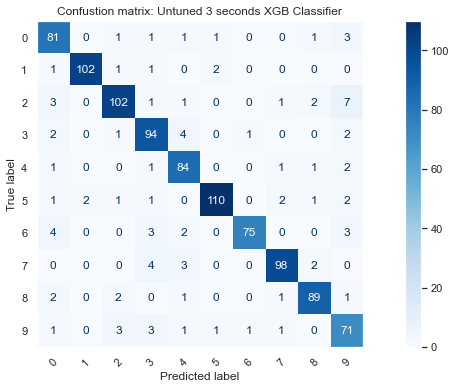

Accuracy : 0.91
Macro F-1 Score : 0.90


In [20]:
# Evaluate Model on Test set
class_labels = list(model_xgb.classes_)
macro_f1, accuracy = evaluate_model(predsTestxgb, y_test, class_labels,
                                    'Confustion matrix: Untuned 3 seconds XGB Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [21]:
parameters = {"n_estimators": np.linspace(5,100,3,dtype=int),
             "learning_rate": [0.1,0.001,0.01],
             "max_depth": random.sample(range(3, 30),3)}
print(parameters)

{'n_estimators': array([  5,  52, 100]), 'learning_rate': [0.1, 0.001, 0.01], 'max_depth': [28, 27, 3]}


In [22]:
tune_xgb = GridSearchCV(estimator = model_xgb, param_grid = parameters, cv = 5)
tune_xgb.fit(X_dev, y_dev)

KeyboardInterrupt: 

In [11]:
print("Best Score :", tune_xgb.best_score_)
print("Best Parameters :",tune_xgb.best_params_)

Best Score : 0.8667411030517354
Best Parameters : {'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'use_label_encoder': False}


In [12]:
predsDevxgb_tuned = tune_xgb.predict(X_dev)
predsTestxgb_tuned = tune_xgb.predict(X_test)

print("Score on Dev data for xgb using GridSearchCV:", accuracy_score(y_dev, predsDevxgb_tuned))
print("Score on Test data for xgb using GridSearchCV:",accuracy_score(y_test, predsTestxgb_tuned))

Score on Dev data for xgb using GridSearchCV: 0.9991241241241241
Score on Test data for xgb using GridSearchCV: 0.8803803803803804


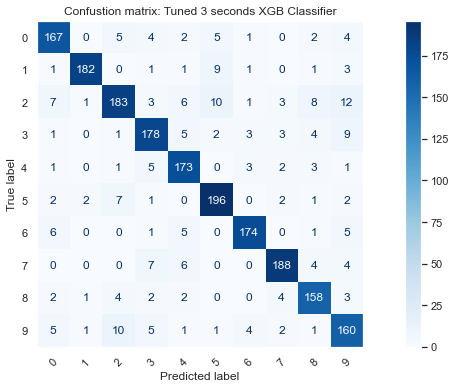

Accuracy : 0.88
Macro F-1 Score : 0.88


In [13]:
# Evaluate Model on Test set
class_labels = list(model_xgb.classes_)
macro_f1, accuracy = evaluate_model(predsTestxgb_tuned, y_test, class_labels,
                                    'Confustion matrix: Tuned 3 seconds XGB Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Dimensionality reduction of data using PCA

In [14]:
# Principal Component Analysis 
### cite : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

# create the PCA instance
pca = PCA(n_components=30)
# fit on data
pca_data = pca.fit_transform(X_dev)
pca_data_test = pca.transform(X_test)
# pca_data_dev = pca.transform(X_dev)
PCA_df= pd.DataFrame(data=pca_data)
y_dev.index = PCA_df.index
pca_final=pd.concat([PCA_df,y_dev], axis = 1)
# access values
print("Explained Variance of each component:",pca.explained_variance_)
print("Sum of Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance of each component: [0.16211049 0.11190511 0.04944364 0.03409667 0.03089104 0.02431167
 0.0172229  0.01586461 0.01282323 0.01102709 0.00926643 0.00886366
 0.00802953 0.00707012 0.00658936 0.00623254 0.00547418 0.00528017
 0.00521745 0.00492087 0.00474667 0.0042582  0.00403036 0.00356816
 0.00341015 0.00335308 0.00300605 0.0029638  0.00291516 0.00281358]
Sum of Explained Variance: 0.9388885285491954


In [15]:
pca_final.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,0.072299,-0.412844,0.023072,-0.417214,0.299826,-0.088897,-0.140614,-0.010051,-0.051669,-0.117334,...,0.023169,0.138793,0.011023,-0.036212,-0.029435,0.015744,-0.040542,0.115637,-0.010201,6
1,0.274582,-0.006478,-0.298496,-0.242299,0.143267,0.006231,-0.135088,0.275194,-0.056233,-0.017892,...,0.029478,0.047746,0.018985,-0.025718,-0.003517,0.006477,-0.049900,0.041291,-0.007357,5
2,0.317181,-0.069387,-0.276547,-0.327404,0.098027,0.062285,-0.227106,-0.017670,-0.096380,-0.190231,...,-0.008501,0.091301,0.044737,0.021184,-0.004906,-0.008833,-0.077110,0.112496,0.066666,2
3,-0.291017,-0.097326,0.154852,-0.012074,0.073026,-0.022696,0.001453,0.070617,0.046663,-0.093311,...,0.032979,0.006885,0.039215,0.062813,0.061048,0.073549,0.042442,-0.121788,-0.091820,2
4,-0.879330,0.313246,-0.219645,0.027579,0.029235,-0.272868,0.007777,-0.127965,-0.002723,0.007386,...,0.036877,0.021955,0.028631,-0.011181,-0.088045,-0.035405,-0.035644,-0.017505,-0.015762,1


### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [16]:
model_pca = XGBClassifier()
model_pca.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainxgb = model_pca.predict(pca_data)
pcaTestxgb = model_pca.predict(pca_data_test)

In [17]:
pcatestxgb_score =  accuracy_score(y_test, pcaTestxgb)
pcaxgb_score = accuracy_score(y_dev, pcaTrainxgb)

In [18]:
print("Classification Score for XGB Classifier on Train dataset:\n")
print("Train Score : ", pcaxgb_score)
print("--------------------------------------------------------")
print("Classification Score for XGB Classifier on Test dataset:\n")
print("Test Score :", pcatestxgb_score)

Classification Score for XGB Classifier on Train dataset:

Train Score :  0.9991241241241241
--------------------------------------------------------
Classification Score for XGB Classifier on Test dataset:

Test Score : 0.8428428428428428


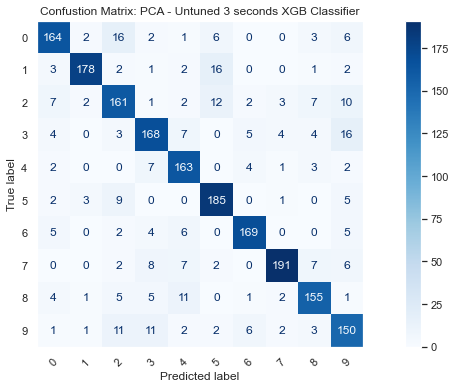

Accuracy : 0.84
Macro F-1 Score : 0.84


In [19]:
# Evaluate Model
class_labels = list(model_xgb.classes_)
macro_f1, accuracy = evaluate_model(pcaTestxgb, y_test, class_labels,
                                    'Confustion Matrix: PCA - Untuned 3 seconds XGB Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [20]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.072299,-0.412844,0.023072,-0.417214,0.299826,-0.088897,-0.140614,-0.010051,-0.051669,-0.117334,...,-0.051825,0.023169,0.138793,0.011023,-0.036212,-0.029435,0.015744,-0.040542,0.115637,-0.010201
1,0.274582,-0.006478,-0.298496,-0.242299,0.143267,0.006231,-0.135088,0.275194,-0.056233,-0.017892,...,-0.012004,0.029478,0.047746,0.018985,-0.025718,-0.003517,0.006477,-0.049900,0.041291,-0.007357
2,0.317181,-0.069387,-0.276547,-0.327404,0.098027,0.062285,-0.227106,-0.017670,-0.096380,-0.190231,...,0.055327,-0.008501,0.091301,0.044737,0.021184,-0.004906,-0.008833,-0.077110,0.112496,0.066666
3,-0.291017,-0.097326,0.154852,-0.012074,0.073026,-0.022696,0.001453,0.070617,0.046663,-0.093311,...,-0.007187,0.032979,0.006885,0.039215,0.062813,0.061048,0.073549,0.042442,-0.121788,-0.091820
4,-0.879330,0.313246,-0.219645,0.027579,0.029235,-0.272868,0.007777,-0.127965,-0.002723,0.007386,...,-0.078904,0.036877,0.021955,0.028631,-0.011181,-0.088045,-0.035405,-0.035644,-0.017505,-0.015762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7987,0.377397,-0.033968,-0.295755,-0.057190,0.151605,0.131654,0.035455,0.102119,-0.002030,0.054440,...,-0.064568,0.012266,0.017713,0.047142,0.039754,-0.061731,-0.041756,-0.009480,0.027611,0.017001
7988,-0.213167,-0.620013,-0.158077,0.127757,0.026842,-0.228274,0.075253,0.001349,0.024656,-0.152193,...,0.004154,-0.026212,0.038713,-0.028687,-0.006777,0.000074,-0.026549,0.022783,0.007211,0.036482
7989,0.376878,-0.370960,0.473148,-0.024045,-0.082251,0.189682,0.059474,0.106883,0.152484,0.122026,...,-0.003571,0.111339,0.009788,0.138647,0.015649,-0.034249,0.085876,0.034356,0.021254,0.088934
7990,-0.395842,0.347525,-0.030944,-0.205586,0.025496,-0.198467,-0.050448,-0.159266,-0.205566,0.063855,...,-0.080729,-0.029940,-0.007235,0.027088,-0.059123,0.048012,0.130293,-0.003312,-0.045496,0.026654


In [21]:
model_pca_tuned = tune_xgb
model_pca_tuned.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainxgb_tuned = model_pca_tuned.predict(pca_data)
pcaTestxgb_tuned = model_pca_tuned.predict(pca_data_test)

In [22]:
pcatestxgb_score =  accuracy_score(y_test, pcaTestxgb)
pcaxgb_score = accuracy_score(y_dev, pcaTrainxgb)

In [23]:
print("Classification Score for XGB Classifier on Train dataset:\n")
print("Train Score : ", pcaxgb_score)
print("--------------------------------------------------------")
print("Classification Score for XGB Classifier on Test dataset:\n")
print("Test Score :", pcatestxgb_score)

Classification Score for XGB Classifier on Train dataset:

Train Score :  0.9991241241241241
--------------------------------------------------------
Classification Score for XGB Classifier on Test dataset:

Test Score : 0.8428428428428428


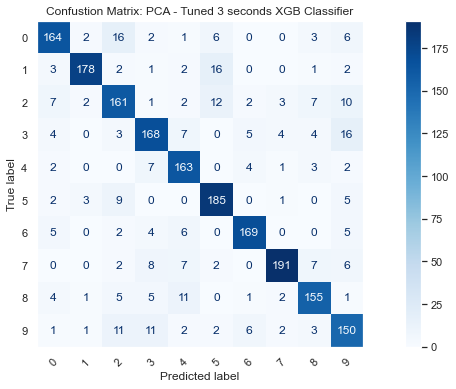

Accuracy : 0.84
Macro F-1 Score : 0.84


In [24]:
# Evaluate Model
class_labels = list(model_xgb.classes_)
macro_f1, accuracy = evaluate_model(pcaTestxgb, y_test, class_labels,
                                    'Confustion Matrix: PCA - Tuned 3 seconds XGB Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)